In [239]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import timeit
from numpy import linalg as LA #for matrix norm
from datetime import date
date = date.today()

#start time
start_time = timeit.default_timer()

#Define global parameters
beta=0.0
endtime=5
#nSteps=6000
#dt=0.001
CFL=1;

#space discritization
N=int(512)
x0=0.0
xN=2*np.pi
#xN=np.pi
x=np.linspace(x0,xN,N, endpoint=False)
y=np.linspace(x0,xN,N, endpoint=False)
x1,x2=np.meshgrid(x,y)
dx=x[2]-x[1]
print('dx = ',dx)

#Wavenumbers 
L = 2.0*np.pi
#L=np.pi
x = np.arange(-N/2,N/2)*(L/N) 
k = np.fft.fftfreq(N)*N*2*np.pi/L
filtr = np.ones_like(k)
k_max = np.max(np.abs(k))
filtr[np.where(np.abs(k)>k_max*0.50)] = 0.
k1,k2=np.meshgrid(k,k)
k11=np.sqrt(k1*k1+k2*k2)
k11[0,0]=0.001 
k=1./(np.power(k11,(2-beta))) #1/|k|
k[0,0]=0
filtr1,filtr2=np.meshgrid(filtr,filtr)
myfilter=filtr1*filtr2

#2/3 dealiasing
myfilter=np.ones(N)
for i in range(N):
    if i>N/3-1 and i<5*N/6-2:
        myfilter[i]=0

myfilter1,myfilter2=np.meshgrid(myfilter,myfilter)
myfilter=myfilter1*myfilter2

#Initial data
theta=np.sin(x1)*np.sin(x2)+np.cos(x2) #period L=2*np.pi
type='type1'


#theta=-(np.cos(2*x1)*np.cos(x2)+np.sin(x1)*np.sin(x2)) #period L=2*np.pi
#type='type2'

#theta=np.cos(2*x1)*np.cos(x2)+np.sin(x1)*np.sin(x2)+np.cos(2*x1)*np.sin(3*x2) #period L=2*np.pi
#type='type3'

#theta=np.sin(4*x1)*np.sin(4*x2)+np.cos(6*x2) #period L=np.pi
#type='type4'

print('Initial Data =', type)

initial_l2_norm=dx*np.round(LA.norm(theta),6)
#L2 Norm of the initial data
print('L2 norm of initial data =',initial_l2_norm) #L2 norm
#L_infinity of initial datain
initial_l_infinity_norm=dx*np.round(LA.norm(theta, np.inf),6)
print('L_infinity norm of initial data =',initial_l_infinity_norm)

#Fourier transform
theta1=np.fft.fft2(theta)

#Gradient of Theta
def grad(theta):
    theta1=np.fft.fft2(theta)
    theta1x1=1j*k1*theta1
    theta1x2=1j*k2*theta1
    thetax1=np.real(np.fft.ifft2(theta1x1))
    thetax2=np.real(np.fft.ifft2(theta1x2))
    return np.sqrt(thetax1*thetax1+thetax2*thetax2)
    #L_infinity norm of gradient theta

    
max_grad=[]
initial_l_infinity_normm_gradtheta=dx*np.round(LA.norm(grad(theta), np.inf),6)
print('L_infinity norm of initial grad theta =',initial_l_infinity_normm_gradtheta)

max_grad.append(initial_l_infinity_normm_gradtheta)



dx =  0.01227184630308513
Initial Data = type1
L2 norm of initial data = 5.441398095922386
L_infinity norm of initial data = 6.283185307179586
L_infinity norm of initial grad theta = 7.640395573225352


In [240]:
#Velocity x comp -The argument must be in Fourier Space
def ux(f1):
    f1=f1*myfilter
    psi=k*f1
    u1=(-1.0)*1.0j*k2*psi
    u=np.real(np.fft.ifft2(u1)) 
    return u

In [241]:
#Velocity y comp -The argument must be in Fourier Space
def uy(f1):
    f1=f1*myfilter
    psi=k*f1
    v1=1.0j*k1*psi
    v=np.real(np.fft.ifft2(v1))
    return v

In [242]:
#dt=CFL*(dx/(np.max(np.max(np.abs(ux(theta1))))+np.max(np.max(np.abs(uy(theta1))))))

In [243]:
dt

440306498.6509189

In [244]:
# Right side function
def f(f1):
    u=ux(f1)
    v=uy(f1)
    f=np.real(np.fft.ifft2(f1)) 
    uf=u*f
    vf=v*f
    uf1=np.fft.fft2(uf)*myfilter 
    vf1=np.fft.fft2(vf)*myfilter 
    return -(1.0j*k1*uf1+1.0j*k2*vf1)

In [245]:
#f(theta1)

In [246]:
#RK4 Routine,
def rk4(x,dt):
    k1=f(x)
    k2=f(x+0.5*dt*k1)
    k3=f(x+0.5*dt*k2)
    k4=f(x+dt*k3)
    x=x+(dt/6.0)*(k1+2.0*k2+2.0*k3+k4)#Time integration
    return x

#Forward Euler Routine
def euler(x,dt):
    return x+dt*f(x)

In [247]:
t=0
iteration=0


In [ ]:
#Iterations begin for time integration
while t<endtime:
    thetafinal=np.real(np.fft.ifft2(theta1))#theta before possible blow up
    #calculating dt using CFL condition
    dt=CFL*(dx/(np.max(np.max(np.abs(ux(theta1))))+np.max(np.max(np.abs(uy(theta1))))))
    #time integration
    theta1=rk4(theta1,dt)#RK4
    #theta1=euler(theta1,dt)#Forward Euler
    theta=np.real(np.fft.ifft2(theta1))
    t=t+dt
    iteration=iteration+1
    if np.isnan(np.max(np.max(theta))):
        n=round(i*dt,6)
        message='Singularity at t = '+str(n)
        print(message)
        break
        
print('time=',t)
print('number of iterations =',iteration)
#Calculating CPU run time for computation
end_time = timeit.default_timer()
CPU_run_time=np.round(end_time - start_time,2)
print('Total CPU run Time: ',CPU_run_time ,'seconds')

In [233]:
#Calculating total time
n=round(endtime,4)

In [234]:
#Calculating L2 and L_infinity Norms
final_l2_norm=dx*np.round(LA.norm(thetafinal),6)
final_l_infinity_norm=dx*np.round(LA.norm(thetafinal, np.inf),6)
print('t= '+str(n )) #L2 norm
print('L2 norm of final data: '+str(final_l2_norm)) #L2 norm
print('L_infinity norm of final data: '+str(final_l_infinity_norm)) #Infinity Norm

#max norm of gradient theta
final_l_infinity_norm_gradtheta=dx*np.round(LA.norm(grad(thetafinal), np.inf),6)
print('t= '+str(n )+ ', L_infinity norm of final grad theta: '+str(final_l_infinity_norm_gradtheta))



t= 1
L2 norm of final data: 5.441398095922386
L_infinity norm of final data: 5.978392602142514
t= 1, L_infinity norm of final grad theta: 7.958764634099373


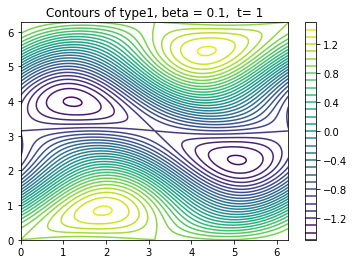

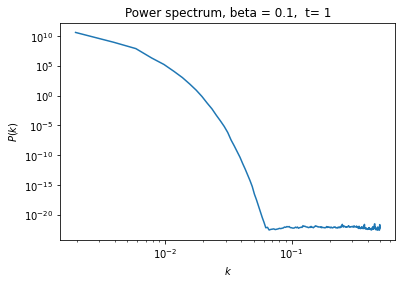

In [235]:
#Plotting contour plot of final theta
plt.contour(x1,x2,thetafinal,30)
plt.colorbar()
plt.title('Contours of '+type+', beta = '+str(round(beta,4)) + ',  t= '+str(n ))


plt.show()

#Plottinng Power Spectrum 
nx = thetafinal.shape[0]
theta1 = np.fft.fftn(thetafinal)
amplitudes = np.abs(theta1)**2
k = np.fft.fftfreq(nx) * nx
k1,k2 = np.meshgrid(k, k)
knrm = np.sqrt(k1**2 + k2**2)
knrm = knrm.flatten()
amplitudes = amplitudes.flatten()
kbins = np.arange(0.5, nx//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])/N
Abins, _, _ = stats.binned_statistic(knrm, amplitudes,
                                        statistic = "mean",
                                        bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
plt.loglog(kvals, Abins)
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.title('Power spectrum, beta = '+str(round(beta,4)) + ',  t= '+str(n ))

plt.show()

In [236]:
dt

479883396.6721409